In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pathlib
import sys
from copy import deepcopy
from typing import Tuple

import geopandas as gpd

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.colors as mcolors
import plotly.express as px
import seaborn as sns
import xarray as xr
from matplotlib import cm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples

gpd.options.io_engine = "pyogrio"

sys.path.append("../")

from visualizations.scripts.drawer import russia_plots


def pca95(df: pd.DataFrame) -> np.ndarray:
    # scale_df = StandardScaler().fit_transform(df)
    scale_df = df
    pca_trans = PCA(n_components=0.95, random_state=42)
    pca_trans.fit(scale_df)

    reduced_df = pca_trans.transform(scale_df)

    return reduced_df


def get_silhouette_scores(features: np.ndarray) -> Tuple[dict]:
    """Calculate the mean and min silhouette score of a range of possible cluster numbers.

    Parameters
    ----------
    features : np.ndarray
        Array containing the input features.

    Returns
    -------
    mean_scores : dict
        Dictionary containing the mean silhouette scores for each cluster number
    min_scores : dict
        Dictionary containing the min silhouette scores for each cluster number

    """
    mean_scores, min_scores = {}, {}
    min_scores = {}
    for n_clusters in range(3, 20, 1):
        clusterer = KMeans(n_clusters=n_clusters, random_state=0, init="k-means++")
        cluster_labels = clusterer.fit_predict(features)
        silhouette_scores = silhouette_samples(X=features, labels=cluster_labels, metric="euclidean")
        mean_scores[n_clusters] = np.mean(silhouette_scores)
        min_scores[n_clusters] = np.min(silhouette_scores)

    return mean_scores, min_scores


def lim_definer(area: float):
    lim_1, lim_2, lim_3, lim_4 = 100, 2000, 10000, 50000

    if area < lim_1:
        return "< 100 $км^2$"
    elif (area >= lim_1) & (area <= lim_2):
        return "100 $км^2$ - 2 000 $км^2$"
    elif (area > lim_2) & (area <= lim_3):
        return "2 000 $км^2$ - 10 000 $км^2$"
    elif (area > lim_3) & (area <= lim_4):
        return "10 000 $км^2$ - 50 000 $км^2$"
    else:
        return "> 50 000 $км^2$"

In [6]:
hbv_table = pd.read_csv(
    "../conclusions/tables/HBV_res_mle_NSE.csv",
    index_col="gauge_id",
    dtype={"gauge_id": str},
)
gr4j_table = pd.read_csv(
    "../conclusions/tables/GR4J_res_mle_NSE.csv",
    index_col="gauge_id",
    dtype={"gauge_id": str},
)
rfr_table = pd.read_csv(
    "../conclusions/tables/res_rfr_cv.csv",
    index_col="gauge_id",
    dtype={"gauge_id": str},
)
lstm_table = pd.read_csv(
    "../conclusions/tables/cudalstm_q_mm_day_mswep_res.csv",
    index_col="gauge_id",
    dtype={"gauge_id": str},
)

### Read and prepare geometry

In [33]:
gauges_file = gpd.read_file("../data/geometry/russia_gauges.gpkg")
gauges_file["gauge_id"] = gauges_file["gauge_id"].astype(str)
gauges_file = gauges_file.set_index("gauge_id")

ws_file = gpd.read_file("../data/geometry/russia_ws.gpkg")
ws_file = ws_file.set_index("gauge_id")
ws_file["size"] = ws_file.loc[:, "new_area"].apply(lambda x: lim_definer(x))
ws_file["size"] = pd.Categorical(
    ws_file["size"],
    [
        "< 100 $км^2$",
        "100 $км^2$ - 2 000 $км^2$",
        "2 000 $км^2$ - 10 000 $км^2$",
        "10 000 $км^2$ - 50 000 $км^2$",
    ],
)
ws_file = ws_file[ws_file["new_area"] <= 50000]

basemap_data = gpd.read_file("../data/geometry/basemap_2023.gpkg")

basin_districts = gpd.read_file("../data/geometry/basin_districts.gpkg")
basin_districts = basin_districts.reset_index(drop=True)
# fixed umgs shapes
basin_districts = basin_districts.reindex(
    [
        0,
        1,
        2,
        3,
        4,
        5,
        6,
        7,
        8,
        26,
        10,
        11,
        12,
        27,
        14,
        15,
        16,
        17,
        18,
        19,
        20,
        21,
        22,
        23,
        24,
        25,
        9,
        13,
    ]
)
basin_districts = basin_districts.reset_index(drop=True)
basin_districts = basin_districts.rename(columns={"BAS_OKRUG": "name1"})

In [9]:
common_index = (
    hbv_table.index.intersection(gr4j_table.index)
    .intersection(rfr_table.index)
    .intersection(lstm_table.index)
    .intersection(ws_file.index)
)
ws_file = ws_file.loc[common_index, :]
ws_file

,name_ru,name_en,new_area,ais_dif,geometry,size
gauge_id,,,,,,
70158,р.Кичменьга - д.Захарово,r.Kichmen'ga - d.Zaharovo,2010.248,0.012,"POLYGON ((45.28625 60.47375, 45.28625 60.47292...",2 000 $км^2$ - 10 000 $км^2$
8290,р.Карабула - с.Карабула,r.Karabula - s.Karabula,4057.005,3.174,"POLYGON ((97.48458 58.34292, 97.48458 58.34208...",2 000 $км^2$ - 10 000 $км^2$
70583,р.Уфтюга - с.Богородское,r.Uftjuga - s.Bogorodskoe,830.751,8.171,"POLYGON ((39.57042 60.42708, 39.57208 60.42708...",100 $км^2$ - 2 000 $км^2$
76408,р.Ай - г.Златоуст,r.Aj - g.Zlatoust,1072.801,4.214,"POLYGON ((59.77542 55.31375, 59.77792 55.31375...",100 $км^2$ - 2 000 $км^2$
72668,р.Алоля - д.Ермолово,r.Alolja - d.Ermolovo,683.497,9.351,"POLYGON ((29.32792 56.87792, 29.32792 56.87708...",100 $км^2$ - 2 000 $км^2$
...,...,...,...,...,...,...
10584,р.Тисулька - пгт Тисуль,r.Tisul'ka - pgt Tisul',229.857,5.925,"POLYGON ((88.43542 55.77792, 88.43542 55.77708...",100 $км^2$ - 2 000 $км^2$
72577,р.Луга - г.Кингисепп,r.Luga - g.Kingisepp,12388.675,3.213,"POLYGON ((29.57208 59.61875, 29.57292 59.61875...",10 000 $км^2$ - 50 000 $км^2$
8347,р.Топорок - г.Алзамай,r.Toporok - g.Alzamaj,1959.655,1.525,"POLYGON ((98.23958 55.62375, 98.24625 55.62375...",100 $км^2$ - 2 000 $км^2$


### Read static data

In [10]:
static_attrs = pd.read_csv("../data/static_data.csv")
static_attrs["gauge_id"] = static_attrs["gauge_id"].astype(str)
static_attrs = static_attrs.set_index("gauge_id")
# adjust indexes in accordance to size of data
static_attrs = static_attrs.loc[common_index, :]

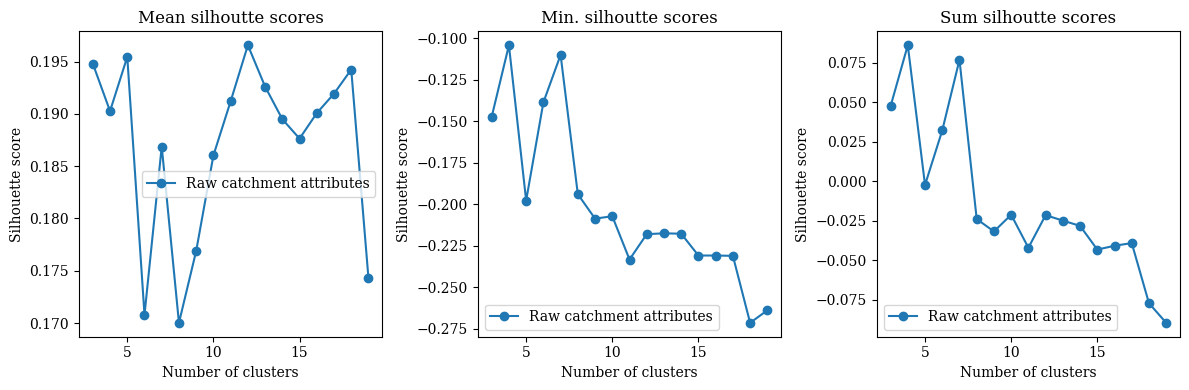

In [11]:
# static_attrs = pd.read_csv("../data/attributes/static_with_height.csv")
static_attrs = pd.read_csv("../data/static_data.csv")
static_attrs["gauge_id"] = static_attrs["gauge_id"].astype(str)
static_attrs = static_attrs.set_index("gauge_id")
# adjust indexes in accordance to size of data
static_attrs = static_attrs.loc[common_index, :]
# static_attrs = static_attrs.dropna(axis=1)

static_parameters = [
    "for_pc_sse",
    "crp_pc_sse",
    "inu_pc_ult",
    "ire_pc_sse",
    "lka_pc_use",
    "prm_pc_sse",
    "pst_pc_sse",
    "cly_pc_sav",
    "slt_pc_sav",
    "snd_pc_sav",
    "kar_pc_sse",
    "urb_pc_sse",
    "gwt_cm_sav",
    "lkv_mc_usu",
    "rev_mc_usu",
    "ws_area",
    "ele_mt_sav",
]
# static_attrs = static_attrs[static_parameters]
df_norm = (static_attrs - static_attrs.mean()) / static_attrs.std()
df_norm = df_norm.dropna(axis=1)
raw_features = df_norm.values


# static_cluster_data = deepcopy(static_attrs)
# static_cluster_data = static_cluster_data.dropna()

# static_cluster_data.loc[:, :] = StandardScaler().fit_transform(
#     static_cluster_data.values
# )

# pca_vals = pca95(static_cluster_data)
# static_pca = pd.DataFrame(
#     columns=[f"pc_{i}" for i in range(pca_vals.shape[1])],
#     index=static_cluster_data.index,
# )
# static_pca.index.name = "gauge_id"
# static_pca.loc[:, :] = pca_vals
raw_scores_means, raw_scores_mins = get_silhouette_scores(raw_features)


def dict_subtract(dict1, dict2):
    """Subtract the values of two dictionaries.

    Parameters
    ----------
    dict1 : dict
        The first dictionary.
    dict2 : dict
        The second dictionary.

    Returns
    -------
    subtract_dict : dict
        A dictionary containing the subtracted values between dict1 and dict2.

    """
    subtract_dict = {}
    for key in dict1.keys():
        if key in dict2.keys():
            subtract_dict[key] = dict1[key] + dict2[key]
        else:
            subtract_dict[key] = dict1[key]
    for key in dict2.keys():
        if key not in dict1.keys():
            subtract_dict[key] = dict2[key]
    return subtract_dict


raw_score_max = dict_subtract(raw_scores_means, raw_scores_mins)

fig, ax = plt.subplots(ncols=3, figsize=(12, 4))
ax[0].plot(
    list(raw_scores_means.keys()),
    list(raw_scores_means.values()),
    marker="o",
    markevery=1,
    label="Raw catchment attributes",
)
ax[0].set_xlabel("Number of clusters")
ax[0].set_ylabel("Silhouette score")
ax[0].set_title("Mean silhoutte scores")
ax[0].legend()

ax[1].plot(
    list(raw_scores_mins.keys()),
    list(raw_scores_mins.values()),
    marker="o",
    markevery=1,
    label="Raw catchment attributes",
)
ax[1].set_xlabel("Number of clusters")
ax[1].set_ylabel("Silhouette score")
ax[1].set_title("Min. silhoutte scores")
ax[1].legend()

ax[2].plot(
    list(raw_score_max.keys()),
    list(raw_score_max.values()),
    marker="o",
    markevery=1,
    label="Raw catchment attributes",
)
ax[2].set_xlabel("Number of clusters")
ax[2].set_ylabel("Silhouette score")
ax[2].set_title("Sum silhoutte scores")
ax[2].legend()

plt.tight_layout()

### Build correlation matrix for parameters

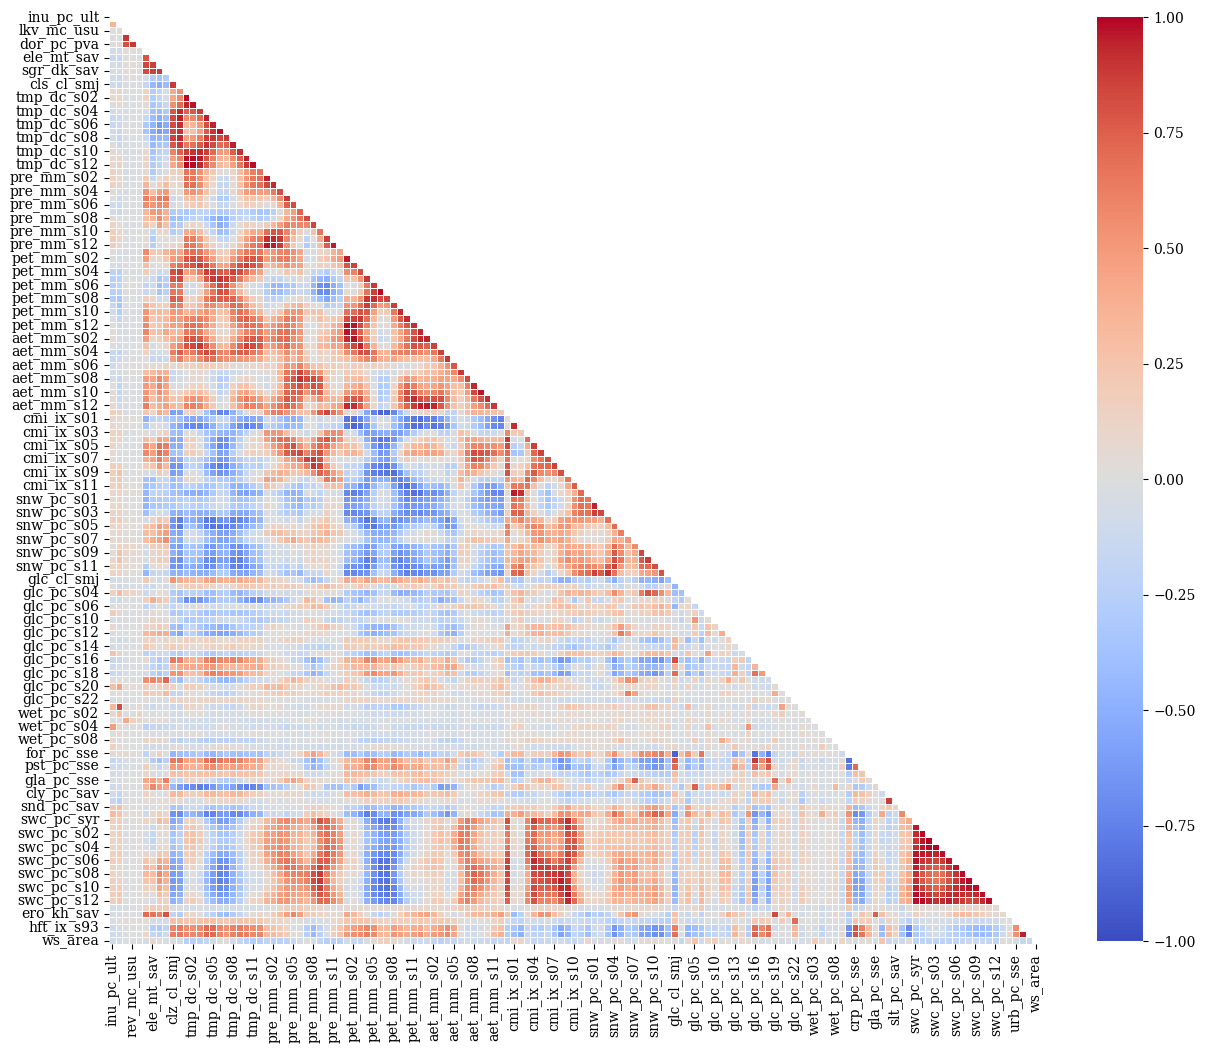

In [12]:
correlation_matrix = df_norm.corr()
correlation_matrix = correlation_matrix.where(
    np.tril(np.ones(correlation_matrix.shape), k=-1).astype(bool)
)
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(
    correlation_matrix,
    cmap="coolwarm",
    ax=ax,
    robust=True,
    vmax=1.0,
    vmin=-1.0,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
);

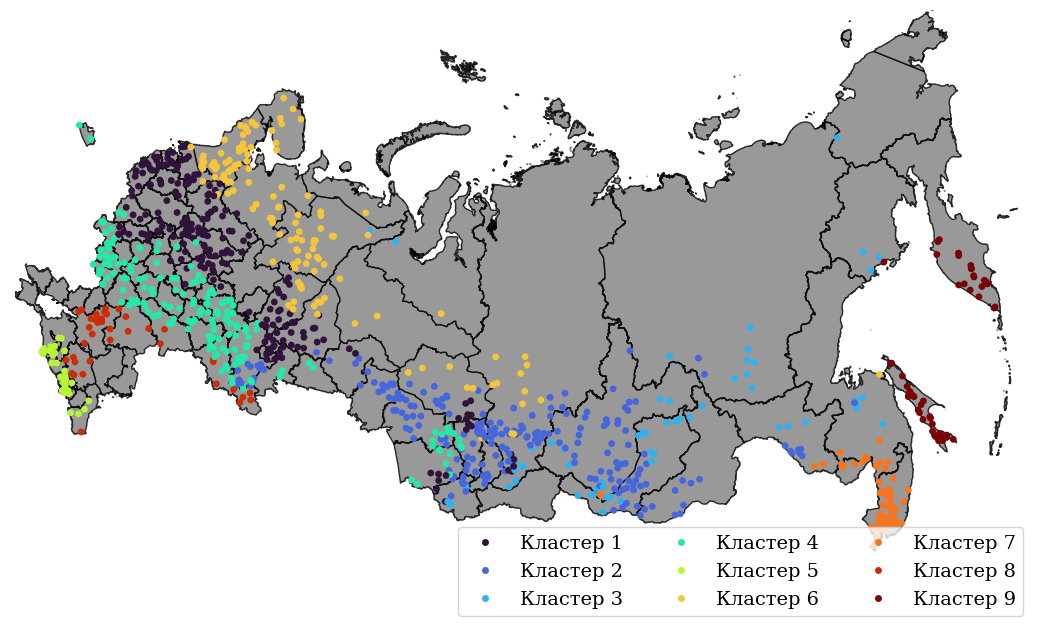

In [14]:
number_of_clusters = 9

# cluster_alg = SpectralClustering(
#     n_clusters=number_of_clusters,
#     random_state=42,
#     # affinity="rbf",
#     assign_labels="kmeans",
#     n_neighbors=df_norm.__len__() // number_of_clusters,
# )
cluster_alg = KMeans(
    n_clusters=number_of_clusters, random_state=42, init="k-means++", n_init=420
)
# cluster_alg = AgglomerativeClustering(
#     n_clusters=number_of_clusters, linkage="ward", compute_full_tree=True
# )

yhat_AC = cluster_alg.fit_predict(df_norm)
df_norm["ResClust"] = [i + 1 for i in yhat_AC]

gauges_file["ResClust"] = np.nan
static_attrs["ResClust"] = np.nan

gauges_file = gauges_file.combine_first(df_norm).dropna()
static_attrs = static_attrs.combine_first(df_norm).dropna()
gauges_file["Кластер"] = [f"Кластер {int(i)}" for i in gauges_file["ResClust"]]

gauges_fig = russia_plots(
    gdf_to_plot=gauges_file,
    basemap_data=basemap_data,
    distinction_col="Кластер",
    cmap_name="turbo",
    #   metric_col='Кластер',
    list_of_limits=list(range(1, 5)),
    figsize=(15, 8),
    just_points=True)

In [15]:
cluster_stats = list()
for i, group_id in df_norm.groupby("ResClust").groups.items():
    g_clust = df_norm.loc[group_id, static_parameters].mean().to_frame().T
    g_clust.index = [i]
    g_clust.index.name = "Кластер"
    cluster_stats.append(g_clust)
cluster_stats = pd.concat(cluster_stats)
cluster_stats = cluster_stats.reset_index()
polar = pd.melt(cluster_stats, id_vars=["Кластер"])

russian_names = {
    "for_pc_sse": "Лесистость",
    "crp_pc_sse": "Пахотные земли",
    "inu_pc_ult": "Затапливаемые территории",
    "ire_pc_sse": "Орошаемые территории",
    "lka_pc_use": "Озерность",
    "prm_pc_sse": "Мерзлотные территории",
    "pst_pc_sse": "Пастбища",
    "cly_pc_sav": "Глинистость",
    "slt_pc_sav": "Осадочные породы",
    "snd_pc_sav": "Песчаные породы",
    "kar_pc_sse": "Карстовые породы",
    "urb_pc_sse": "Урбанизированные территории",
    "gwt_cm_sav": "Глубина первого водоносного горизонта",
    "lkv_mc_usu": "Объём озёр",
    "rev_mc_usu": "Объём водохранилищ",
    "ws_area": "Площадь водосбора",
    "ele_mt_sav": "Средняя высота водосбора",
}

polar["variable"] = [russian_names[i] for i in polar["variable"]]

In [16]:
cmap_name: str = "RdYlGn"
cmap = cm.get_cmap(cmap_name, number_of_clusters)
color_list = [mcolors.rgb2hex(cmap(i)) for i in range(cmap.N)]

fig_polar = px.line_polar(
    polar,
    r="value",
    theta="variable",
    color="Кластер",
    color_discrete_sequence=color_list,
    template="seaborn",
    height=1000,
    width=1000,
)
fig_polar.update_layout(
    polar=dict(
        radialaxis=dict(showticklabels=False, ticks=""),
        angularaxis=dict(showticklabels=True, tickangle=0),
    ),
    legend_title_text="Кластеры",
    legend=dict(
        orientation="h",
        yanchor="middle",
        y=-0.1,
        xanchor="center",
        x=0.5,
        bgcolor=None,
        bordercolor="Black",
        borderwidth=0,
    ),
)
# fig_polar.write_image("./images/cluster_importance_tft.png")
fig_polar

/tmp/ipykernel_26961/1349290237.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name, number_of_clusters)


### Clusters based on streamflow

In [17]:
available_gauges = list(
    i.stem
    for i in pathlib.Path("../data/ws_related_meteo/nc_all_q/").glob("*.nc")
    if i.stem in common_index
)

In [18]:
average_q_df = pd.DataFrame()

for gauge_id in available_gauges:
    with xr.open_dataset(f"../data/ws_related_meteo/nc_all_q/{gauge_id}.nc") as f:
        yearly_file = f.to_dataframe()
        yearly_average = (
            yearly_file[["q_mm_day"]]
            .groupby([yearly_file.index.month, yearly_file.index.day])
            .mean()
            .values.ravel()
        )
    average_q_df.loc[:, gauge_id] = yearly_average

average_q_df = average_q_df.loc[:, average_q_df.max() < 100]
q_df_clust = deepcopy(average_q_df.T)
q_df_clust.columns = q_df_clust.columns.astype(str)
gauges_clust = deepcopy(gauges_file)
q_df_clust = (q_df_clust - q_df_clust.mean()) / q_df_clust.std()
for gauge_id in q_df_clust.index:
    for i in range(1):
        q_df_clust.loc[gauge_id, f"lat_{i}"] = gauges_clust.loc[gauge_id, "geometry"].x
        q_df_clust.loc[gauge_id, f"lon_{i}"] = gauges_clust.loc[gauge_id, "geometry"].y

/tmp/ipykernel_26961/854962035.py:12: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_26961/854962035.py:12: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_26961/854962035.py:12: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipykernel_26961/854962035.py:12: Performance

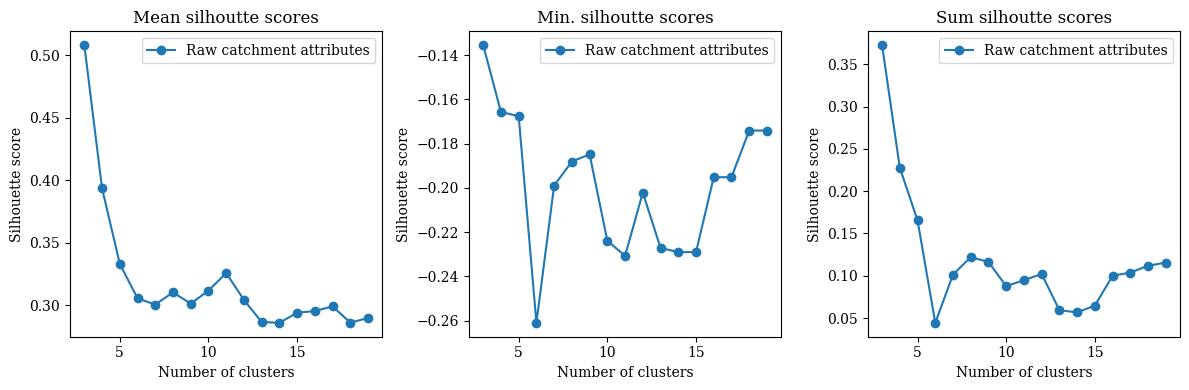

In [19]:
# q_df_clust = q_df_clust[static_parameters]
# df_norm = (q_df_clust - q_df_clust.mean()) / q_df_clust.std()
df_norm = deepcopy(q_df_clust)
df_norm = df_norm.dropna(axis=1)
raw_features = df_norm.values

# static_cluster_data = deepcopy(q_df_clust)
# static_cluster_data = static_cluster_data.dropna()

# static_cluster_data.loc[:, :] = StandardScaler().fit_transform(
#     static_cluster_data.values
# )

# pca_vals = pca95(static_cluster_data)
# static_pca = pd.DataFrame(
#     columns=[f"pc_{i}" for i in range(pca_vals.shape[1])],
#     index=static_cluster_data.index,
# )
# static_pca.index.name = "gauge_id"
# static_pca.loc[:, :] = pca_vals
raw_scores_means, raw_scores_mins = get_silhouette_scores(raw_features)


def dict_subtract(dict1, dict2):
    """Subtract the values of two dictionaries.

    Parameters
    ----------
    dict1 : dict
        The first dictionary.
    dict2 : dict
        The second dictionary.

    Returns
    -------
    subtract_dict : dict
        A dictionary containing the subtracted values between dict1 and dict2.

    """
    subtract_dict = {}
    for key in dict1.keys():
        if key in dict2.keys():
            subtract_dict[key] = dict1[key] + dict2[key]
        else:
            subtract_dict[key] = dict1[key]
    for key in dict2.keys():
        if key not in dict1.keys():
            subtract_dict[key] = dict2[key]
    return subtract_dict


raw_score_max = dict_subtract(raw_scores_means, raw_scores_mins)

fig, ax = plt.subplots(ncols=3, figsize=(12, 4))
ax[0].plot(
    list(raw_scores_means.keys()),
    list(raw_scores_means.values()),
    marker="o",
    markevery=1,
    label="Raw catchment attributes",
)
ax[0].set_xlabel("Number of clusters")
ax[0].set_ylabel("Silhouette score")
ax[0].set_title("Mean silhoutte scores")
ax[0].legend()

ax[1].plot(
    list(raw_scores_mins.keys()),
    list(raw_scores_mins.values()),
    marker="o",
    markevery=1,
    label="Raw catchment attributes",
)
ax[1].set_xlabel("Number of clusters")
ax[1].set_ylabel("Silhouette score")
ax[1].set_title("Min. silhoutte scores")
ax[1].legend()

ax[2].plot(
    list(raw_score_max.keys()),
    list(raw_score_max.values()),
    marker="o",
    markevery=1,
    label="Raw catchment attributes",
)
ax[2].set_xlabel("Number of clusters")
ax[2].set_ylabel("Silhouette score")
ax[2].set_title("Sum silhoutte scores")
ax[2].legend()

plt.tight_layout()

для 1 нашлось 20 объектов
для 2 нашлось 171 объектов
для 3 нашлось 133 объектов
для 4 нашлось 88 объектов
для 5 нашлось 198 объектов
для 6 нашлось 126 объектов
для 7 нашлось 21 объектов
для 8 нашлось 27 объектов
для 9 нашлось 205 объектов


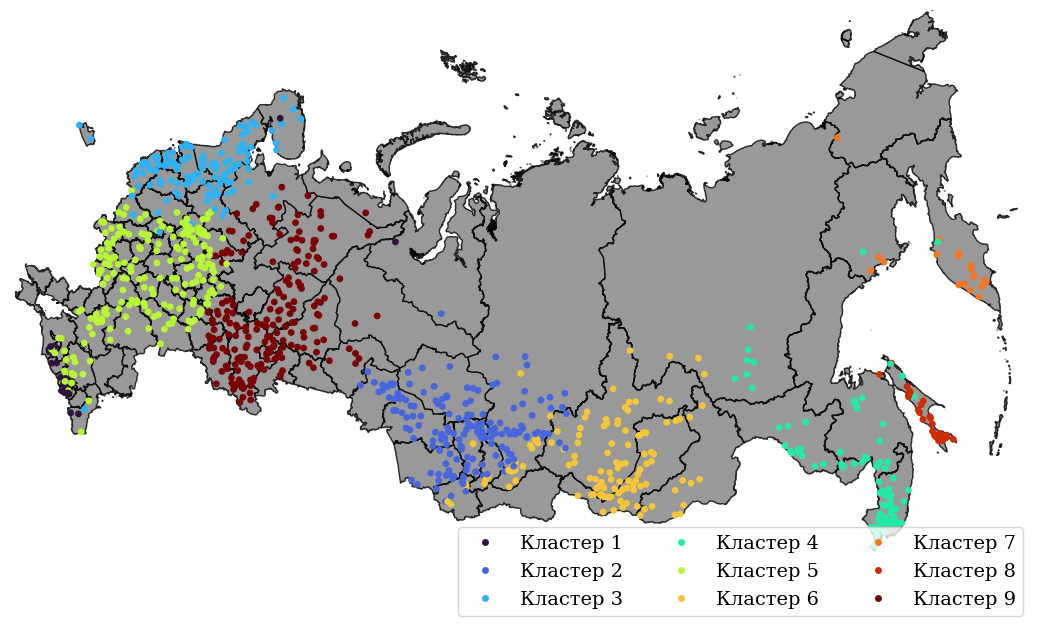

In [21]:
number_of_clusters = 9
# cluster_alg = AgglomerativeClustering(
#     n_clusters=number_of_clusters, linkage="ward", compute_full_tree=True
# )
cluster_alg = KMeans(
    n_clusters=number_of_clusters,
    random_state=42,
    init="k-means++",
)


yhat_AC = cluster_alg.fit_predict(df_norm)
df_norm["ResClust"] = [i + 1 for i in yhat_AC]
bad_clusters = list()
for i, idx in df_norm.groupby("ResClust").groups.items():
    print(f"для {i} нашлось {len(idx)} объектов")
    if len(idx) < 5:
        bad_clusters.append(i)

df_norm = df_norm.loc[~df_norm["ResClust"].isin(bad_clusters), :]


gauges_clust["ResClust"] = np.nan

gauges_clust = gauges_clust.combine_first(df_norm).dropna()
gauges_clust["Кластер"] = [f"Кластер {int(i)}" for i in gauges_clust["ResClust"]]

gauges_fig = russia_plots(
    gdf_to_plot=gauges_clust,
    basemap_data=basemap_data,
    distinction_col="Кластер",
    cmap_name="turbo",
    #   metric_col='Кластер',
    list_of_limits=list(range(1, number_of_clusters)),
    figsize=(15, 8),
    just_points=True,
    with_histogram=False,
)

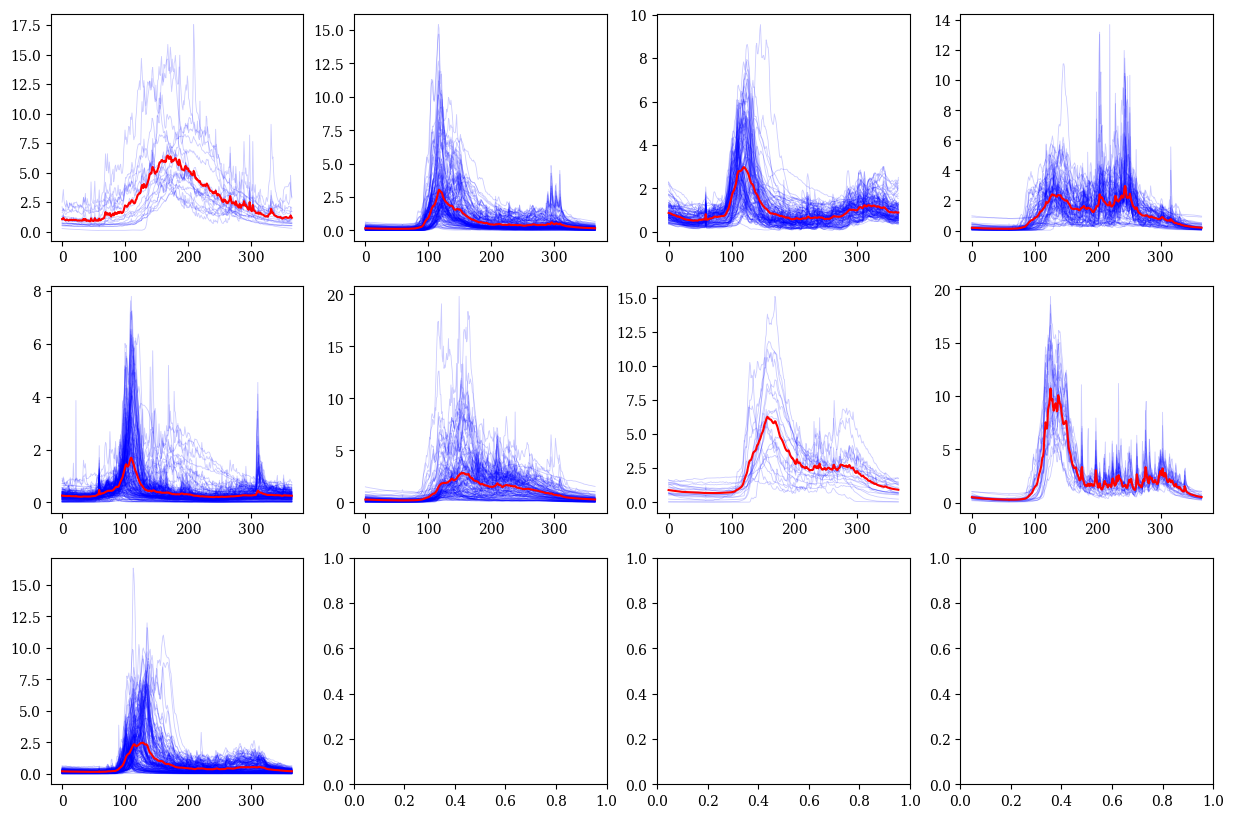

In [22]:
cluster_q_mm = dict()
for clust_id, group_id in df_norm.groupby("ResClust").groups.items():
    cluster_q_mm[clust_id] = list()
    for gauge_id in group_id:
        with xr.open_dataset(f"../data/ws_related_meteo/nc_all_q/{gauge_id}.nc") as f:
            yearly_file = f.to_dataframe()
            yearly_file = yearly_file[["q_mm_day"]]
        cluster_q_mm[clust_id].append(yearly_file)
    cluster_q_mm[clust_id] = pd.concat(cluster_q_mm[clust_id], axis=1)
    cluster_q_mm[clust_id].columns = group_id

fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))

for clust_ax, (clust_id, clust_data) in zip(ax.flatten(), cluster_q_mm.items()):
    clust_avg = (
        clust_data.groupby([clust_data.index.month, clust_data.index.day])
        .mean()
        .reset_index(drop=True)
        .mean(axis=1)
        .values.ravel()
    )

    mean_by_gauge = (
        clust_data.groupby([clust_data.index.month, clust_data.index.day]).mean().reset_index(drop=True)
    )

    # Define a consistent color and transparency level
    line_color = "blue"  # Example color
    line_alpha = 0.2  # Transparency level (0.0 to 1.0)

    for gauge_id in mean_by_gauge.columns:
        clust_ax.plot(
            mean_by_gauge.index.values,
            mean_by_gauge[f"{gauge_id}"].values,
            color=line_color,
            alpha=line_alpha,
            linewidth=0.6,
        )
    clust_ax.plot(mean_by_gauge.index.values, clust_avg, color="red", alpha=1.0)
# fig.delaxes(ax[-1][-1])

In [49]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 10))

for clust_ax, (clust_id, clust_data) in zip(ax.flatten(), cluster_q_mm.items()):
    clust_avg = (
        clust_data.groupby([clust_data.index.month, clust_data.index.day])
        .median()
        .reset_index(drop=True)
        .median(axis=1)
        .values.ravel()
    )

    mean_by_gauge = (
        clust_data.groupby([clust_data.index.month, clust_data.index.day])
        .median()
        .reset_index(drop=True)
    )

    # Define a consistent color and transparency level
    line_color = "blue"  # Example color
    line_alpha = 0.2  # Transparency level (0.0 to 1.0)

    for gauge_id in mean_by_gauge.columns:
        clust_ax.plot(
            mean_by_gauge.index.values,
            mean_by_gauge[f"{gauge_id}"].values,
            color=line_color,
            alpha=line_alpha,
            linewidth=0.6,
        )
    clust_ax.plot(mean_by_gauge.index.values, clust_avg, color="red", alpha=1.0)
# fig.delaxes(ax[-1][-1])

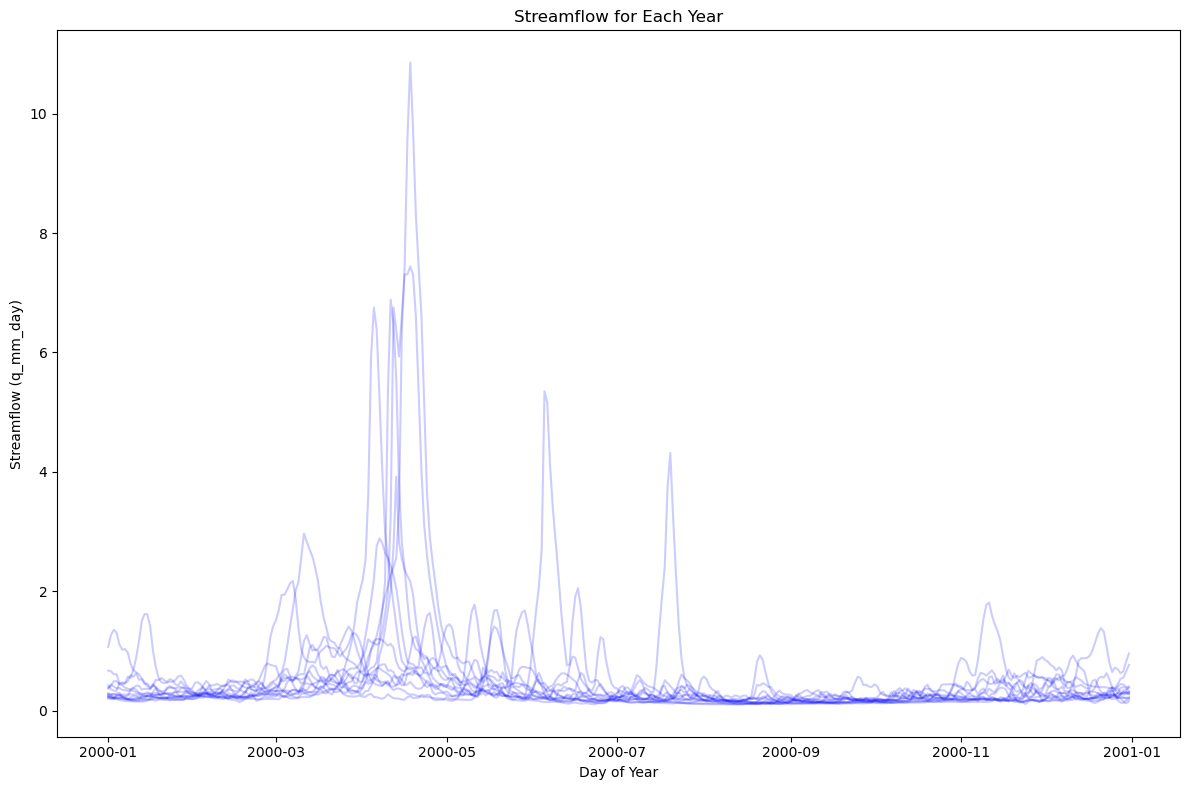

In [277]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming `test_clust` is your DataFrame and it has a DateTimeIndex
# If `test_clust` doesn't have a DateTimeIndex, you would need to set it. For example:
# test_clust.index = pd.to_datetime(test_clust.index)

# Extract the year from the index
test_clust["Year"] = test_clust.index.year

# Get unique years
unique_years = test_clust["Year"].unique()


# Loop through each year and plot the data
for year in unique_years:
    # Select the data for the current year
    data_for_year = test_clust[test_clust["Year"] == year]

    # Normalize the index to a common starting point for all years, e.g., "2000-01-01"
    # This is necessary to overlay the plots on the same x-axis scale
    normalized_index = pd.to_datetime(
        "2000-"
        + data_for_year.index.month.astype(str).str.zfill(2)
        + "-"
        + data_for_year.index.day.astype(str).str.zfill(2)
    ).values

    # Plot the data with consistent color and transparency
    plt.plot(
        normalized_index,
        data_for_year["q_mm_day"].values,
        color=line_color,
        alpha=line_alpha,
    )

plt.xlabel("Day of Year")
plt.ylabel("Streamflow (q_mm_day)")
plt.title("Streamflow for Each Year")
plt.tight_layout()
plt.show()

### Dominant static attribute

In [28]:
static_table = pd.read_csv("../conclusions/tables/feature_ranking.csv")
static_table = static_table.set_index("Unnamed: 0")
static_table.index.name = ""
static_table = static_table.drop("ws_area")
russian_names = {
    "for_pc_sse": "Лесистость",
    "crp_pc_sse": "Пахотные земли",
    "inu_pc_ult": "Затапливаемые территории",
    "ire_pc_sse": "Орошаемые территории",
    "lka_pc_use": "Озерность",
    "prm_pc_sse": "Мерзлотные территории",
    "pst_pc_sse": "Пастбища",
    "cly_pc_sav": "Глинистость",
    "slt_pc_sav": "Осадочные породы",
    "snd_pc_sav": "Песчаные породы",
    "kar_pc_sse": "Карстовые породы",
    "urb_pc_sse": "Урбанизированные территории",
    "gwt_cm_sav": "Глубина первого водоносного горизонта",
    "lkv_mc_usu": "Объём озёр",
    "rev_mc_usu": "Объём водохранилищ",
    "ws_area": "Площадь водосбора",
    "ele_mt_sav": "Средняя высота водосбора",
}
feature_df = pd.DataFrame()
for gauge_id in static_table.columns:
    feature_df.loc[gauge_id, "feature"] = russian_names[
        static_table.index[np.argmax(static_table.loc[:, gauge_id])]
    ]
for i, idx in feature_df.groupby("feature").groups.items():
    print(f"для {i} нашлось {len(idx)} объектов")
    gauges_file = gpd.read_file("../data/geometry/russia_gauges.gpkg")
    gauges_file["gauge_id"] = gauges_file["gauge_id"].astype(str)
    gauges_file = gauges_file.set_index("gauge_id")
    gauges_file["feature"] = np.nan

    gauges_file = gauges_file.combine_first(feature_df.loc[idx, :]).dropna()

для Глинистость нашлось 12 объектов
для Глубина первого водоносного горизонта нашлось 262 объектов
для Затапливаемые территории нашлось 14 объектов
для Карстовые породы нашлось 1 объектов
для Лесистость нашлось 42 объектов
для Мерзлотные территории нашлось 59 объектов
для Объём водохранилищ нашлось 277 объектов
для Озерность нашлось 111 объектов
для Орошаемые территории нашлось 18 объектов
для Осадочные породы нашлось 6 объектов
для Пастбища нашлось 60 объектов
для Пахотные земли нашлось 143 объектов
для Песчаные породы нашлось 8 объектов
для Средняя высота водосбора нашлось 88 объектов
для Урбанизированные территории нашлось 10 объектов


In [32]:
feature_df


,feature
75402,Объём водохранилищ
9283,Объём водохранилищ
3210,Пахотные земли
72102,Пахотные земли
76486,Озерность
...,...
7039,Объём водохранилищ
8288,Глубина первого водоносного горизонта
71277,Глубина первого водоносного горизонта
19382,Средняя высота водосбора


In [ ]:

    gauges_fig = russia_plots(
        gdf_to_plot=gauges_file,
        basemap_data=basemap_data,
        distinction_col="feature",
        cmap_name="tab20",
        #   metric_col='Кластер',
        list_of_limits=list(range(1, 5)),
        figsize=(15, 8),
        just_points=True,
        with_histogram=False,
    )

In [34]:
gauges_file


,name_ru,name_en,geometry
gauge_id,,,
49001,р.Ковда - пос.Софпорог,r.Kovda - pos.Sofporog,POINT (31.41892 65.79876)
49014,р.Корпи-Йоки - пос.Пяозерский,r.Korpi-Joki - pos.Pjaozerskij,POINT (31.05794 65.77917)
49017,р.Тумча - пос.Алакуртти,r.Tumcha - pos.Alakurtti,POINT (30.33082 66.95957)
49030,р.Кузема - ст.Кузема,r.Kuzema - st.Kuzema,POINT (34.23039 65.37582)
49047,р.Судно - с.Вокнаволок,r.Sudno - s.Voknavolok,POINT (30.50502 64.95504)
...,...,...,...
4240,р.Бирюкан - пос.Восточный,r.Birjukan - pos.Vostochnyj,POINT (143.03127 53.49538)
1105,руч.Встреча - выше устья руч.Угроза,ruch.Vstrecha - vyshe ust'ja ruch.Ugroza,POINT (147.66247 61.85056)
4005,р.Охинка - г.Оха,r.Ohinka - g.Oha,POINT (142.93783 53.57969)


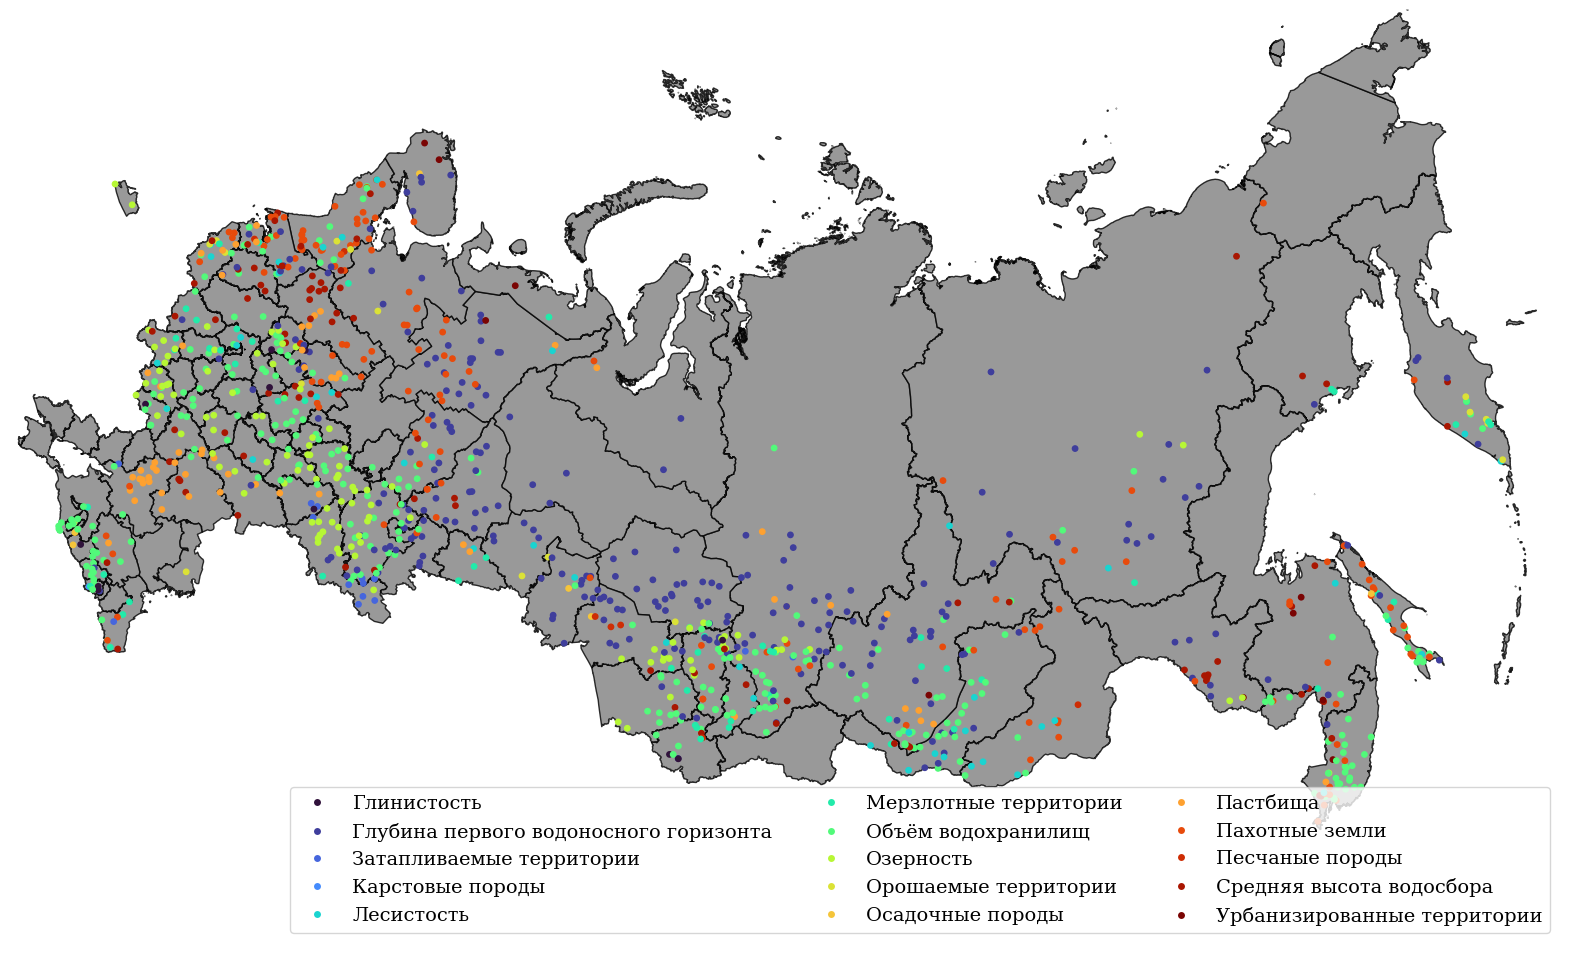

In [46]:
gauges_file["feature"] = np.nan
static_attrs["feature"] = np.nan

gauges_file = gauges_file.combine_first(feature_df).dropna()
static_attrs = static_attrs.combine_first(feature_df).dropna()

gauges_fig = russia_plots(
    gdf_to_plot=gauges_file,
    basemap_data=basemap_data,
    distinction_col="feature",
    cmap_name="turbo",
    #   metric_col='Кластер',
    list_of_limits=list(range(1, 17)),
    figsize=(20, 25),
    just_points=True,
)
